# SEIR Model
[SIER](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SEIR_model) model with the effects of societal intervention included.

I have taken the equations from this web app: http://gabgoh.github.io/COVID/index.html

Kernel on which it is based: https://www.kaggle.com/saga21/covid-global-forecast-sir-model

**Possible Improvements**
* Add a time dependent CFR
* Use the observed R decay in Asian countries to condition R in countries who are yet to see a decay in R
* Clean up data for the early stages of the US since the lack of early testing has heavily biased the data

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from tqdm.notebook import tqdm
from scipy.integrate import solve_ivp

%matplotlib inline
np.version.version

'1.18.1'

In [2]:
# Susceptible equation
def dS_dt(S, I, R_t, T_inf):
    return -(R_t / T_inf) * I * S

# Exposed equation
def dE_dt(S, E, I, R_t, T_inf, T_inc):
    return (R_t / T_inf) * I * S - (T_inc**-1) * E

# Infected equation
def dI_dt(I, E, T_inc, T_inf):
    return (T_inc**-1) * E - (T_inf**-1) * I

# Recovered/deceased equation
def dR_dt(I, T_inf):
    return (T_inf**-1) * I

def SEIR_model(t, y, R_t, T_inf, T_inc):
    
    if callable(R_t):
        reproduction = R_t(t)
    else:
        reproduction = R_t
    
    S, E, I, R = y
    S_out = dS_dt(S, I, reproduction, T_inf)
    E_out = dE_dt(S, E, I, reproduction, T_inf, T_inc)
    I_out = dI_dt(I, E, T_inc, T_inf)
    R_out = dR_dt(I, T_inf)
    return [S_out, E_out, I_out, R_out]

In [3]:
N = 100000  # Population size
n_infected = 1
max_days = 200

# State at time = 0 for SEIR model
a = (N - n_infected)/ N
b = 0
c = n_infected / N
d = 0.

In [4]:
def plot_model(solution, title='SEIR model'):
    sus, exp, inf, rec = solution.y

    f = plt.figure(figsize=(8,5)) 
    plt.plot(sus, 'b', label='Susceptible');
    plt.plot(exp, 'y', label='Exposed');
    plt.plot(inf, 'r', label='Infected');
    plt.plot(rec, 'c', label='Recovered/deceased');
    plt.title(title)
    plt.xlabel("Days", fontsize=10);
    plt.ylabel("Fraction of population", fontsize=10);
    plt.legend(loc='best');

# Model without intervention
Let's see what the model looks like without any intervention, i.e. `R_0` is a contant value

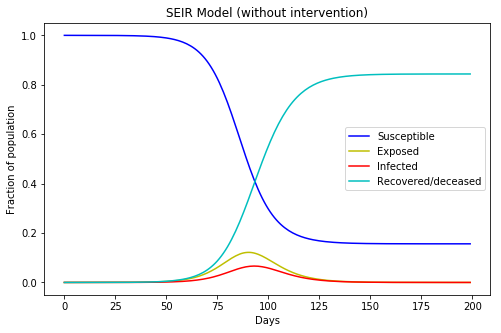

In [5]:
T_inc = 5.2
T_inf = 2.9  
R_0 = 2.2  

sol = solve_ivp(SEIR_model, [0, max_days], [a, b, c, d], args=(R_0, T_inf, T_inc), 
                t_eval=np.arange(max_days))

plot_model(sol, 'SEIR Model (without intervention)')

# Model with intervention
Lets assume that there is some intervention that causes the reproduction number (`R_0`) to fall to a lower value (`R_t`) at a certain time (e.g. physical distancing). Note that the actual drop will occur some time after the intervention measures are implemented.

This could be modified to take any function of `R_t(t)` values to model the reproduction number as a time varying variable

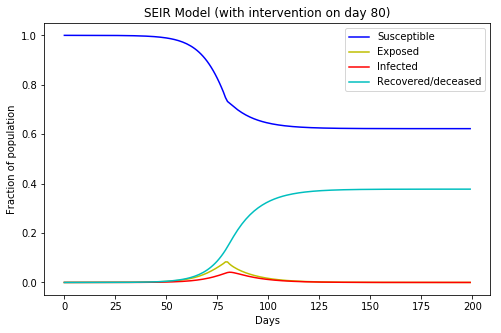

In [6]:
T_inc = 5.2  # average incubation period
T_inf = 2.9  # average infectious period
R_0 = 2.2  # reproduction number without intervention
R_t = 0.7  # reproduction number after intervention
intervention_day = 80

def time_varying_reproduction(t):
    if t > intervention_day:
        return R_t
    else:
        return R_0

sol2 = solve_ivp(SEIR_model, [0, max_days], [a, b, c, d], args=(time_varying_reproduction, T_inf, T_inc), 
                t_eval=np.arange(max_days))

plot_model(sol2, f'SEIR Model (with intervention on day {intervention_day})')

Let's compare the infection rate between the two cases

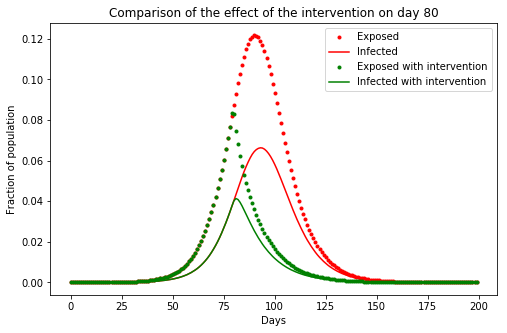

In [7]:
_, exp, inf, _ = sol.y
_, exp2, inf2, _ = sol2.y

f = plt.figure(figsize=(8,5)) 
plt.plot(exp, 'r.', label='Exposed');
plt.plot(inf, 'r', label='Infected');
plt.plot(exp2, 'g.', label='Exposed with intervention');
plt.plot(inf2, 'g', label='Infected with intervention');
plt.title(f'Comparison of the effect of the intervention on day {intervention_day}')
plt.xlabel("Days", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best');

You can see that after the intervention on day 80, the peak infections is lower than if there was no intervention

# Fitting the model to data
There are certain variables assicated with the model to fit it to real life data:
* Average incubation period, `T_inc`
* Average infection period, `T_inf`
* Reproduction number, `R_0` or `R_t`
* Case fatality rate, `CFR`

The first two are to be constants specific to the virus. The latter two are likely to be time dependent variables dependent on factors such as:
* When a government intervened
* Peoples behaviours (do people actively self-isolate, not visit religious shrines etc.)
* Population demographic of a country (is a significant proportion of the population old?)
* Heathcare system capacity (hostpital beds per capita)
* Number of tests

We try to derive the time dependent R_t and CFR from the data. 

We compare this to just using a single reproduction number. This might actaully be more suitable in countries where the outbreak has just started or they are struggling to limit the spread.

We use a Hill decay, which has 2 parameters, `k` and `L` (the half decay constant):

In [8]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://raw.githubusercontent.com/wiki/SwissTPH/openmalaria/img/graphs/decay-functions.png")

In [9]:


train = pd.read_csv('train.csv', parse_dates=['Date'])
test = pd.read_csv('test.csv', parse_dates=['Date'])
submission = pd.read_csv('submission.csv', index_col=['ForecastId'])

# Load the population data into lookup dicts
pop_info = pd.read_csv('population_data.csv')
country_pop = pop_info.query('Type == "Country/Region"')
province_pop = pop_info.query('Type == "Province/State"')
country_lookup = dict(zip(country_pop['Name'], country_pop['Population']))
province_lookup = dict(zip(province_pop['Name'], province_pop['Population']))

train['FatalityRate'] = train['Fatalities'] / train['ConfirmedCases']
train['Area'] = train['Province/State'].fillna(train['Country/Region'])
test['Area'] = test['Province/State'].fillna(test['Country/Region'])

# Remove the leaking data
train_full = train.copy()
valid = train[train['Date'] >= test['Date'].min()]
train = train[train['Date'] < test['Date'].min()]

# Split the test into public & private
test_public = test[test['Date'] <= '2020-03-25']
test_private = test[test['Date'] > '2020-03-25']

# Use a multi-index for easier slicing
train_full.set_index(['Area', 'Date'], inplace=True)
train.set_index(['Area', 'Date'], inplace=True)
valid.set_index(['Area', 'Date'], inplace=True)
test_public.set_index(['Area', 'Date'], inplace=True)
test_private.set_index(['Area', 'Date'], inplace=True)

submission['ConfirmedCases'] = 0
submission['Fatalities'] = 0

train_full.shape, train.shape, valid.shape, test_public.shape, test_private.shape, submission.shape

((17892, 8), (14200, 8), (3692, 8), (3976, 5), (8236, 5), (12212, 2))

In [10]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_log_error, mean_squared_error

The function below evaluates a model with a constant R number and case fatality ratio, CFR. CFR is used to estimate the number of fatalities from the Recovered/deceased compartment in the SEIR model

In [11]:
# Use a constant reproduction number
def eval_model_const(params, data, population, return_solution=False, forecast_days=0):
    R_0, cfr = params
    N = population
    n_infected = data['ConfirmedCases'].iloc[0]
    max_days = len(data) + forecast_days
    a, b, c, d = (N - n_infected)/ N, 0, n_infected / N, 0
               
    sol = solve_ivp(SEIR_model, [0, max_days], [a, b, c, d], args=(R_0, T_inf, T_inc),
                    t_eval=np.arange(0, max_days))
    
    y_pred_cases = np.diff((sol.y[2] + sol.y[3])*N, prepend=n_infected).cumsum()
    y_pred_cases = np.clip(y_pred_cases, 0, np.inf)
    y_true_cases = data['ConfirmedCases'].values
    y_pred_fat = np.clip(sol.y[3]*N, 0, np.inf) * cfr
    y_true_fat = data['Fatalities'].values
    
    optim_days = min(14, len(data))  # Days to optimise for
    weights = 1 / np.arange(1, optim_days+1)[::-1]  # Recent data is more heavily weighted
    
    msle_cases = mean_squared_log_error(y_true_cases[-optim_days:], y_pred_cases[-optim_days:], weights)
    msle_fat = mean_squared_log_error(y_true_fat[-optim_days:], y_pred_fat[-optim_days:], weights)
    msle_final = np.mean([msle_cases, msle_fat])
    
    if return_solution:
        return msle_final, sol
    else:
        return msle_final

The function below is essentially the same as above, by R is decayed using a Hill decay function. This model requires 4 parameters to be optimized, `R_0`, `CFR`, `k` & `L`

In [12]:
# Use a Hill decayed reproduction number
def eval_model_decay(params, data, population, return_solution=False, forecast_days=0):
    R_0, cfr, k, L = params  
    N = population
    n_infected = data['ConfirmedCases'].iloc[0]
    max_days = len(data) + forecast_days
    a, b, c, d = (N - n_infected)/ N, 0, n_infected / N, 0
       
    # Hill decay. Initial values: R_0=2.2, k=2, L=50
    def time_varying_reproduction(t): 
        return R_0 / (1 + (t/L)**k)
            
    sol = solve_ivp(SEIR_model, [0, max_days], [a, b, c, d], args=(time_varying_reproduction, T_inf, T_inc),
                    t_eval=np.arange(0, max_days))
    
    y_pred_cases = np.diff((sol.y[2] + sol.y[3])*N, prepend=n_infected).cumsum()
    y_pred_cases = np.clip(y_pred_cases, 0, np.inf)
    y_true_cases = data['ConfirmedCases'].values
    y_pred_fat = np.clip(sol.y[3]*N, 0, np.inf) * cfr
    y_true_fat = data['Fatalities'].values
    
    optim_days = min(14, len(data))  # Days to optimise for
    weights = 1 / np.arange(1, optim_days+1)[::-1]  # Recent data is more heavily weighted
    
    msle_cases = mean_squared_log_error(y_true_cases[-optim_days:], y_pred_cases[-optim_days:], weights)
    msle_fat = mean_squared_log_error(y_true_fat[-optim_days:], y_pred_fat[-optim_days:], weights)
    msle_final = np.mean([msle_cases, msle_fat])
    
    if return_solution:
        return msle_final, sol
    else:
        return msle_final

In [13]:
def use_last_value(train_data, valid_data, test_data):
    lv = train_data[['ConfirmedCases', 'Fatalities']].iloc[-1].values
    
    forecast_ids = test_data['ForecastId']
    submission.loc[forecast_ids, ['ConfirmedCases', 'Fatalities']] = lv
    
    if valid_data is not None:
        y_pred_valid = np.ones((len(valid_data), 2)) * lv.reshape(1, 2)
        y_true_valid = valid_data[['ConfirmedCases', 'Fatalities']]

        msle_cases = mean_squared_log_error(y_true_valid['ConfirmedCases'], y_pred_valid[:, 0])
        msle_fat = mean_squared_log_error(y_true_valid['Fatalities'], y_pred_valid[:, 1])
        msle_final = np.mean([msle_cases, msle_fat])

        return msle_final

The function below fits a SEIR model for each area, either using a constant R or a decayed R, whichever is better. If the total cases/1M pop is below 1, then the last value is used.

In [25]:
def fit_model(area_name, initial_guess=[2.2, 0.02, 2, 50], 
              bounds=((1, 20), (0.005, 0.15), (1, 3), (1, 100)), make_plot=True):
        
    train_data = train.loc[area_name].query('ConfirmedCases > 0')
    valid_data = valid.loc[area_name]
    test_data = test_public.loc[area_name]
    
    try:
        population = province_lookup[area_name]
    except KeyError:
        population = country_lookup[area_name]
        
    cases_per_million = train_data['ConfirmedCases'].max() * 10**6 / population
    n_infected = train_data['ConfirmedCases'].iloc[0]
        
    if cases_per_million < 1 or area_name == 'US':  # Not sure where the single case in the "US" is
        return use_last_value(train_data, valid_data, test_data)
                
    res_const = minimize(eval_model_const, [2.2, 0.02], bounds=((1, 20), (0.005, 0.15)),
                         args=(train_data, population, False),
                         method='L-BFGS-B')
    
    res_decay = minimize(eval_model_decay, initial_guess, bounds=bounds,
                         args=(train_data, population, False),
                         method='L-BFGS-B')
    
    dates_all = train_data.index.append(test_data.index)
    dates_val = train_data.index.append(valid_data.index)
    
    
    # If using a constant R number is better, use that model
    if res_const.fun < res_decay.fun:
        msle, sol = eval_model_const(res_const.x, train_data, population, True, len(test_data))
        res = res_const
        R_t = pd.Series([res_const.x[0]] * len(dates_val), dates_val)
    else:
        msle, sol = eval_model_decay(res_decay.x, train_data, population, True, len(test_data))
        res = res_decay
        
        # Calculate the R_t values
        t = np.arange(len(dates_val))
        R_0, cfr, k, L = res.x   
        R_t = pd.Series(R_0 / (1 + (t/L)**k), dates_val)
        
    sus, exp, inf, rec = sol.y
    
    y_pred = pd.DataFrame({
        'ConfirmedCases': np.diff((inf + rec) * population, prepend=n_infected).cumsum(),
        'Fatalities': np.clip(rec, 0, np.inf) * population * res.x[1]
    }, index=dates_all)
    
    y_pred_valid = y_pred.iloc[len(train_data): len(train_data)+len(valid_data)]
    y_pred_test = y_pred.iloc[len(train_data):]
    y_true_valid = valid_data[['ConfirmedCases', 'Fatalities']]
        
    valid_msle_cases = mean_squared_log_error(y_true_valid['ConfirmedCases'], y_pred_valid['ConfirmedCases'])
    valid_msle_fat = mean_squared_log_error(y_true_valid['Fatalities'], y_pred_valid['Fatalities'])
    valid_msle = np.mean([valid_msle_cases, valid_msle_fat])
    
    if make_plot:
        print(f'Validation MSLE: {valid_msle:0.5f}', res.x)
        
        f = plt.figure(figsize=(8, 5)) 
        train_data['ConfirmedCases'].plot(label='Confirmed Cases (train)', c='g')
        valid_data['ConfirmedCases'].plot(label='Confirmed Cases (valid)', c='b')
        y_pred.loc[train_data.index, 'ConfirmedCases'].plot(label='Cumulative modeled infections', c='r')
        y_pred.loc[valid_data.index, 'ConfirmedCases'].plot(label='Cumulative modeled infections (forecast)', c='orange', linestyle='-')
        plt.legend(loc='best');
        R_t.plot(label='Reproduction number', c='c', linestyle='-', secondary_y=True)
        plt.title("Train-Test split plot using optimum R_0 (" + area_name +")")
        plt.legend(loc='best');
        
       
    return valid_msle
            

In [26]:
# Fit a model on the full dataset (i.e. no validation)
def fit_model_full(area_name, initial_guess=[2.2, 0.02, 2, 50], 
                   bounds=((1, 20), (0.005, 0.15), (1, 3), (1, 100)), make_plot=True):
        
    train_data = train_full.loc[area_name].query('ConfirmedCases > 0')
    test_data = test_private.loc[area_name]
    
    try:
        population = province_lookup[area_name]
    except KeyError:
        population = country_lookup[area_name]
        
    cases_per_million = train_data['ConfirmedCases'].max() * 10**6 / population
    n_infected = train_data['ConfirmedCases'].iloc[0]
        
    if cases_per_million < 1 or area_name == 'US':  # Not sure where the single case in the "US" is
        return use_last_value(train_data, None, test_data)
                
    res_const = minimize(eval_model_const, [2.2, 0.02], bounds=((1, 20), (0.005, 0.15)),
                         args=(train_data, population, False),
                         method='L-BFGS-B')
    
    res_decay = minimize(eval_model_decay, initial_guess, bounds=bounds,
                         args=(train_data, population, False),
                         method='L-BFGS-B')
    
    dates_all = train_data.index.append(test_data.index)
    
    
    # If using a constant R number is better, use that model
    if res_const.fun < res_decay.fun:
        msle, sol = eval_model_const(res_const.x, train_data, population, True, len(test_data))
        res = res_const
        R_t = pd.Series([res_const.x[0]] * len(dates_all), dates_all)
    else:
        msle, sol = eval_model_decay(res_decay.x, train_data, population, True, len(test_data))
        res = res_decay
        
        # Calculate the R_t values
        t = np.arange(len(dates_all))
        R_0, cfr, k, L = res.x   
        R_t = pd.Series(R_0 / (1 + (t/L)**k), dates_all)
        
    sus, exp, inf, rec = sol.y
    
    y_pred = pd.DataFrame({
        'ConfirmedCases': np.diff((inf + rec) * population, prepend=n_infected).cumsum(),
        'Fatalities': np.clip(rec, 0, np.inf) * population * res.x[1]
    }, index=dates_all)
    
    y_pred_test = y_pred.iloc[len(train_data):]
    
    if make_plot:
        print(res.x)
                
        f = plt.figure(figsize=(8, 5)) 
        train_data['ConfirmedCases'].plot(label='Confirmed Cases (train)', c='g')
        y_pred.loc[train_data.index, 'ConfirmedCases'].plot(label='Cumulative modeled infections', c='r')
        y_pred.loc[test_data.index, 'ConfirmedCases'].plot(label='Cumulative modeled infections (forecast)', c='orange', linestyle='-')
        plt.legend(loc='best');
        R_t.plot(label='Reproduction number', c='c', linestyle='-', secondary_y=True)
        plt.title("Full data plot using optimum R_0 (" + area_name +")")
        plt.legend(loc='best');


Validation MSLE: 0.25826 [3.4929365  0.07668642]
[ 3.70343965  0.12364393  3.         51.75345729]


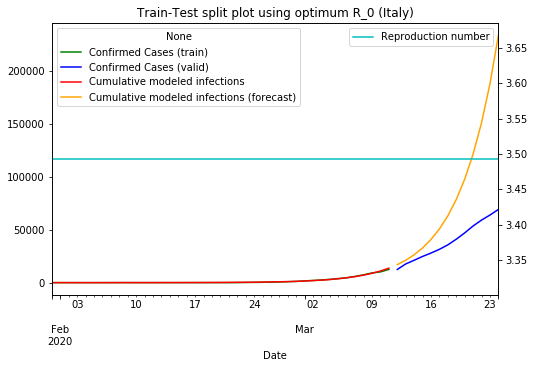

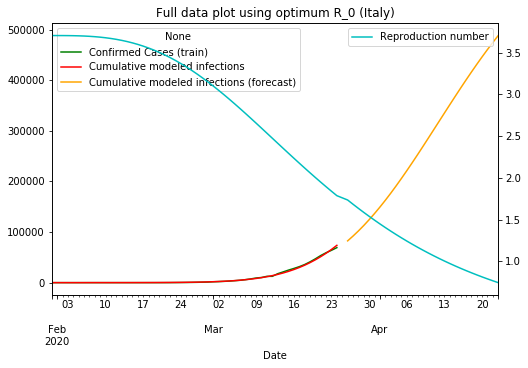

In [27]:
fit_model('Italy')
fit_model_full('Italy')

Above, the model optimized on the last 14 days of data from Italy which has been weighted to put more importance on recent data

The numbers show that `R_0` was around 3.5 and a constant value was a better fit for this data. This means that (for this time period) the measures Italy had in place are unfortunately not showing a reduction in cases.

Validation MSLE: 0.15659 [20.          0.05872531  2.19658326  5.55749609]
[10.15154546  0.08718444  2.91323765 12.56992988]


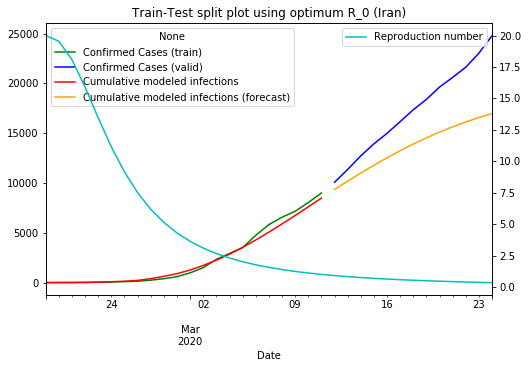

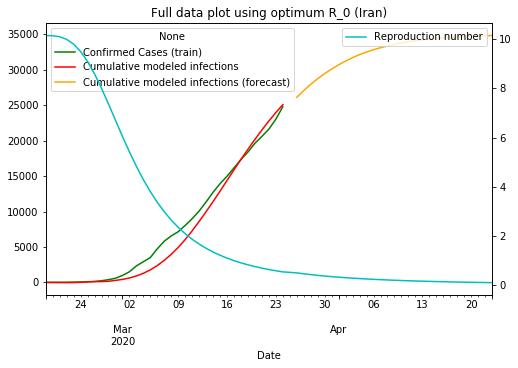

In [29]:
fit_model('Iran')
fit_model_full('Iran')

An unusual feature of the Iranian data is how linear it is, as opposed to log-linear as with Italy's data.

Validation MSLE: 0.52941 [3.58830241e+00 9.59912002e-03 2.23671388e+00 5.00143564e+01]
[2.97474256e+00 1.23444228e-02 2.13753513e+01 4.54837930e+01]


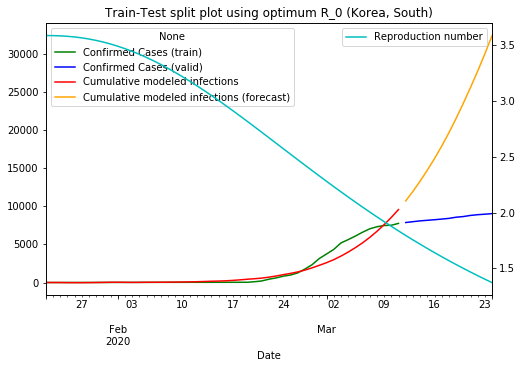

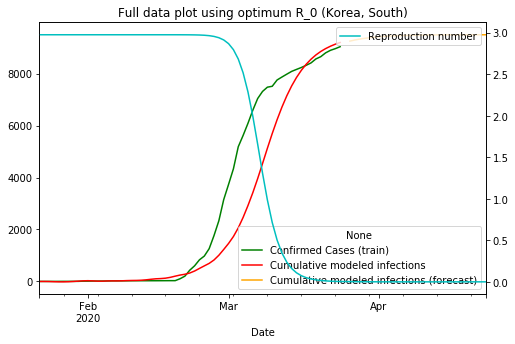

In [30]:
fit_model('Korea, South', bounds=((1, 20), (0.005, 0.15), (1, 100), (1, 200)))
fit_model_full('Korea, South', bounds=((1, 20), (0.005, 0.15), (1, 100), (1, 200)))

South Korea is unusual due to the super-human efforts to stop the spread. In order to model this, the k value in the Hill decay were allowed to go higher than normal values (using wider boundary conditions) which allowed an extremely rapid decay of the reproduction number, but it still isn't enough

Validation MSLE: 0.05601 [2.08966655e+00 2.52502073e-02 8.56699370e+00 5.16909669e+01]
[2.71987382e+00 4.04343625e-02 1.00000000e+00 5.03006290e+01]


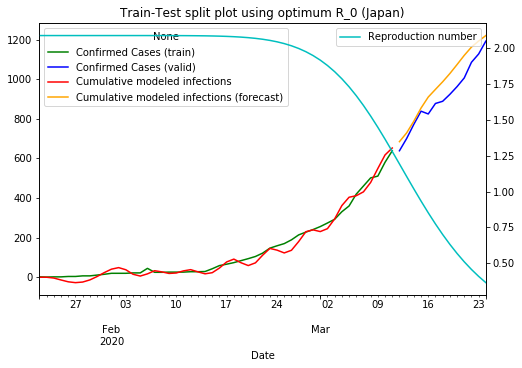

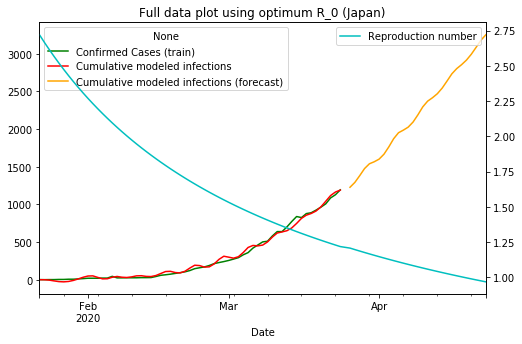

In [33]:
fit_model('Japan', bounds=((1, 20), (0.005, 0.15), (1, 10), (1, 200)))
fit_model_full('Japan', bounds=((1, 20), (0.005, 0.15), (1, 10), (1, 200)))

One of the big questions of the outbreak was how did Japan limit the spread? `R_0` in this case is 2.09 which is on the low side compared to what we have seen in other countries.

Validation MSLE: 28.31965 [20.          0.05603631  2.01611194 50.00009339]
[3.70001127e+00 2.68677372e-02 1.00000000e+00 4.99721545e+01]


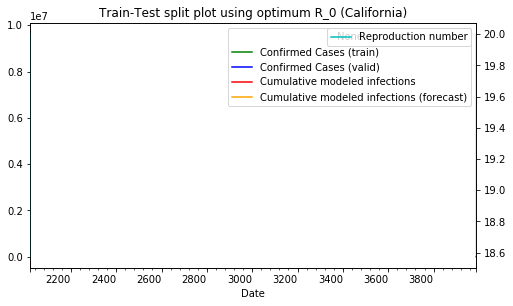

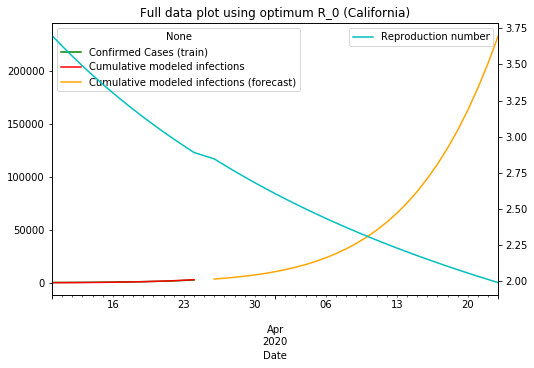

In [34]:
fit_model('California')
fit_model_full('California')

Validation MSLE: 0.00029 [ 4.37791993  0.04430802  3.         13.56663857]
[ 3.73709239  0.04612028  3.         16.46436311]


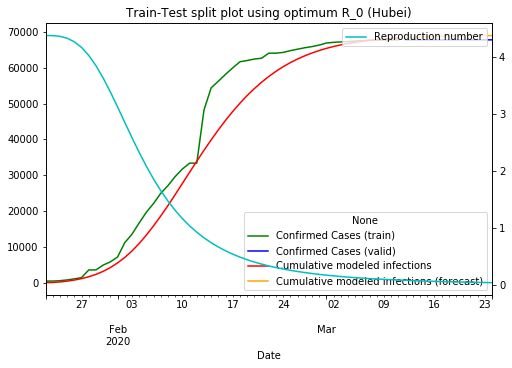

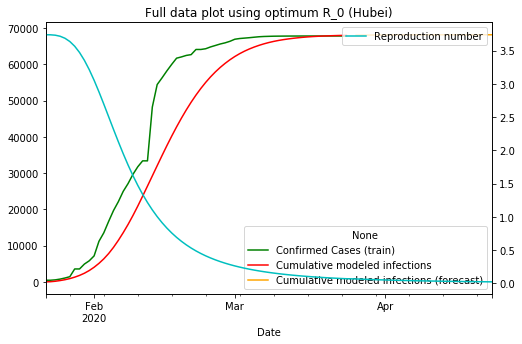

In [35]:
fit_model('Hubei')
fit_model_full('Hubei')

The plot for Hubei looks really good. In fact the data for most of the Chinese provinces is really good and the SEIR model works well

Validation MSLE: 2.77727 [2.15188783 0.01914991]
[2.54030334 0.05518727]


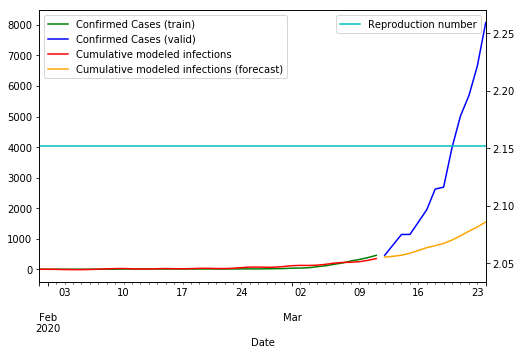

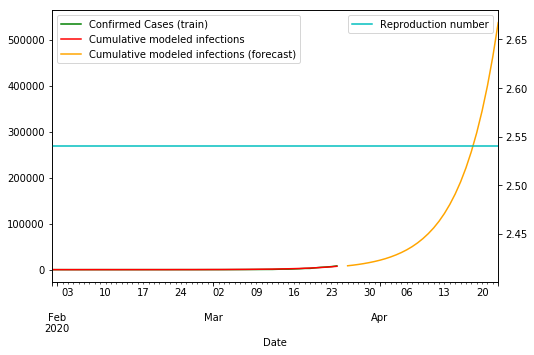

In [22]:
fit_model('United Kingdom')
fit_model_full('United Kingdom')

[4.68145182 0.02472345]


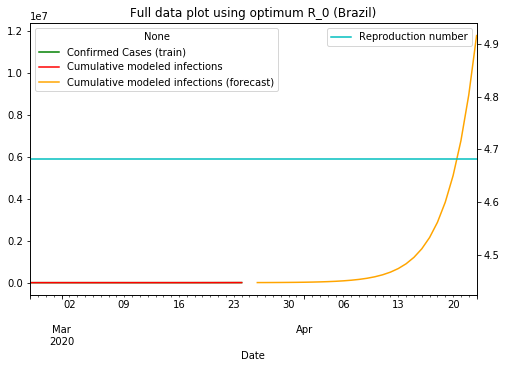

In [36]:
fit_model('Brazil')
fit_model_full('Brazil')

In [26]:
# Find which areas are not being predicted well
validation_scores.sort_values(by=['MSLE'], ascending=False).head(20)

,Country,MSLE
25,California,28.319678
191,Washington,27.462005
105,Massachusetts,26.283126
1,Albania,22.957070
76,Iowa,22.034673
48,Florida,20.825601
121,New Jersey,18.295925
115,Nebraska,17.561292
120,New Hampshire,17.320575
7,Arizona,17.204844


# The SEIR model

SEIR is highly sensitive to the quality of data used to calibrate it. For some countries where the data is good it works well, but in places where testing is sparse (e.g. the US), it really struggles.

California, for example, the jump from 0 to 144 then 177 cases in the space of 3 days is an artefact caused by the testing protocols. I think other models might be more robust to this

SEIR model (and it's derivatives) is best suited for scenario testing using end-point assumptions rather than for generating accurate forecasts
